# Reporte de códigos del clasificador TDAH, CONTROLES.

A continuación, voy a comentar un poco los códigos en esta notebook.
El siguiente bloque de código es para construir los dataframes necesarios y pasárselos a un clasificador binario.

Cargando librerías

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
#import keras 
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
from IPython.display import display, Image

Previamente seleccioné de todos los estudios solamente los electrodos que habíamos acordado. Los guardé en un excel y esos son los que importo como archivos csv. Esto con la finalidad de que no se gastara tanto tiempo de cómputo al generar los dataframes una y otra vez. Mejor los generé una vez, los exporté y esos son los que importo cada vez que quiero hacer pruebas.
Cargamos archivos csv que ya tenemos preparados y les aplicamos la fast fourier transformation.

In [ ]:
os.chdir(r'C:\Users\jairm\Downloads\Controles\Controles\Estudios_nuevos\SE34_PTDAH_OC')
filename = 'Controles_nuevos.csv'
Base_R1 = pd.read_csv(filename, header=None) #De una vez le di el nombre que necesitaba.


#TDAH
os.chdir(r'C:\Users\jairm\Downloads\TDAH\TDAH\Nuevos_estudios\SE29_PTDAH_OC')
filename = 'TDAH_nuevos.csv'
Base_R2 = pd.read_csv(filename, header=None)

#Transformada de Fourier
import scipy.fftpack as fourier 

#print(f'Es el primer type {type(Base_R1)}')
Base_R1=fourier.fft(Base_R1) #se aplica la transformada de fourier a la base1 
#de controles 
#print(f'Es el segundo type {type(Base_R1)}')
Base_R1=abs(Base_R1) #se calcula es valor absoluto de la transformada de fourier
#de la base1 

Base_R1=pd.DataFrame(Base_R1) #volvemos a generar un dataframe del valor absoluto
#de la base1. Esto se corrigio del codigo original 
#display(Base_R1)
"""Acá este dataframe se ve bien. Después lo vuelve a pasar a df, pero se empieza a ver raro. Quizás de eso vienen los problemas."""
#print(f'Es el tercer type {type(Base_R1)}')

Base_R2=fourier.fft(Base_R2) #se aplica la transformada de fourier a la base2 
#de TDAH
Base_R2=abs(Base_R2) #se calcula es valor absoluto de la transformada de fourier
#de la base2
Base_R2 = pd.DataFrame(Base_R2)

Se etiquetan los valores en el dataframe y se separan las variables que queremos predecir del resto del dataframe.
# ¿Cómo etiquetamos?
Las filas del dataframe que construimos representan 2 segundos de la información que recopiló 1 electrodo. Por tanto, si esos 2 segundos provienen de personas con TDAH, se les pone un 0 en una columna al final de todos los datos del df. Si los 2 segundos provienen de personas CONTROL, se les pone un 1. 


In [ ]:
Base_R1_controles=Base_R1
listaa=[] #lista vacia

'''Cambiaría la forma en cómo se llena la lista con unos o ceros. Acá utilizó un ciclo, pero creo que consume muchos menos recursos hacerlo de otra forma.'''
for uno1 in range(len(Base_R1_controles.axes[0])):
    listaa.append(1)
#print(listaa)    
Base_R1_controles['y']=listaa
#print(Base_R1_controles)

#1=controles
Errores_1=Base_R2 #los errores son las base de tdah
listaa=[]

for ceroo in range(len(Errores_1.axes[0])):
    listaa.append(0)
#0=tdah    
Errores_1['y']=listaa
Base_R1_controles=Base_R1_controles.append(Errores_1,ignore_index=True)
val_fal_1=Base_R1_controles.isnull().sum()

y_1=Base_R1_controles.y 
#allY1=y_1
#allY1.append(0)
X_1=Base_R1_controles.drop('y',axis=1)
#############################################

#X = X_1.append(X_2) #se juntan las 'x'
X = np.array(X_1) #se convierten en una matriz nunpy para que entre a la red 
#print(X)

#Y = y_1.append(y_2)
Y = np.array(y_1)
#print(Y)

Se separan los datos de entrenamiento de los datos de test para entrenar y se entrena la red por las épocas mencionadas en el código

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1) #Parece que esta función los revuelve de una vez...


opt = keras.optimizers.RMSprop(learning_rate=0.001)

model = Sequential()
model.add(Dense(len(x_train[1]), activation='sigmoid', input_shape=(len(x_train[1]),)))
model.add(Dropout(0.2))
#model.add(Dense(512, activation='sigmoid'))
#model.add(Dense(512, activation='sigmoid'))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='sigmoid'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer= opt, metrics=("accuracy"))

history=model.fit(x_train, y_train, batch_size=(32),steps_per_epoch=150, epochs=60, verbose=1, 
                  validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

#Vamos a guardar la red para probarla con nuevos datos.
os.chdir(r'C:\Users\jairm\Downloads')
model.save("red_bin_2_epocas_entrenando_mas_datos_v4_60_epocas.h5")

Una vez guardada la red, vamos a probarla con datos que fueron utilizados para el entrenamiento y también para datos que no fueron utilizados para el entrenamiento de la red y que tampoco son del conjunto de test que se definió anteriormente. 
Quise hacerlo así porque a pesar de haber podido utilizar el conjunto de test, al ser de las mismas personas, quizás los datos se parezcan mucho más a los datos de entrenamiento en comparación de los datos provenientes de estudios de personas que nunca había visto la red. Se supone que nuestro modelo debería ser lo suficientemente flexible como para ser aplicado a personas en general.
Quise comparar la cantidad de aciertos de los datos antes vistos con la cantidad de aciertos de los datos nunca antes vistos para ver si había diferencia significativa. Si la hay, es indicativo de que el modelo no aprendió algo, solamente sobreajustó los datos con los que entrenó...

Hay 2 partes para hacer esto:
1 parte
Utilicé el conjunto de electroencefalogramas con el que entrené. Le apliqué las transformadas para darle la misma estructura a los datos que recibió la red. Hice predicciones utilizando el modelo y conté los aciertos y desaciertos (Se explica detenidamente el conteo de estos en la parte del código que lo realiza).

2 parte.
utilicé 2 electroencefalogramas de personas con TDAH y 2 electroencefalogramas de personas CONTROL. Ya tenía preparados los csv con sus datos, por lo que los importé de la misma forma que en el proceso que expliqué después de importar las librerías. Les apliqué después la fast fourier transformation, justo como a los datos de entrenamiento, pues busco darles la misma estructura que los datos con los que estuve entrenando. 

1 parte. Cargarle datos a la red que había visto antes.

In [ ]:
from tensorflow.keras.models import load_model
import os
from turtle import pd
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import os
from termcolor import colored
#Preparando los datos para meterlos a la red y probarla.

#Ya tengo los csv listos, los importaré
#Controles
os.chdir(r'C:\Users\jairm\Downloads\Controles\Controles\Estudios_nuevos\SE34_PTDAH_OC')
filename = 'Controles_nuevos.csv'
Base_R1 = pd.read_csv(filename, header=None) #De una vez le di el nombre que necesitaba.


#TDAH
os.chdir(r'C:\Users\jairm\Downloads\TDAH\TDAH\Nuevos_estudios\SE29_PTDAH_OC')
filename = 'TDAH_nuevos.csv'
Base_R2 = pd.read_csv(filename, header=None)

#Transformada de Fourier
import scipy.fftpack as fourier 

Base_R1=fourier.fft(Base_R1) #se aplica la transformada de fourier a la base1 

Base_R1=abs(Base_R1) #se calcula es valor absoluto de la transformada de fourier
#de la base1 

Base_R1=pd.DataFrame(Base_R1) #volvemos a generar un dataframe del valor absoluto
#de la base1. Esto se corrigio del codigo original 
"""Acá este dataframe se ve bien. Después lo vuelve a pasar a df, pero se empieza a ver raro. Quizás de eso vienen los problemas."""

Base_R2=fourier.fft(Base_R2) #se aplica la transformada de fourier a la base2 
#de TDAH
Base_R2=abs(Base_R2) #se calcula es valor absoluto de la transformada de fourier
#de la base2
Base_R2 = pd.DataFrame(Base_R2) #volvemos a generar un dataframe del valor absoluto

Si yo fuera a entrenar la red de nuevo, tendría que ir al siguiente paso que es ponerles etiquetas, separarlo en datos de prueba y entrenamiento, etc. Pero la red ya está entrenada, lo que voy a hacer el alimentarle los dos datasets que tengo (Base_R1 y Base_R2) para que me haga una predicción. La ventaja es que la Base_R1 es solamente de personas CONTROL, mientras que la Base_R2 son todas personas con TDAH.
# ¿Qué hará la red para predecir?
La estructura del este df es la misma que la que explicamos en la parte de arriba, solo que es más pequeña. Al alimentarle solamente la Base_R1, la red "comerá" filas del df que representan 2 segundos del electroencefalograma de algún sujeto de prueba de alguna persona CONTROL. (Sabemos eso por lo que pusimos en la primera parte de este Markdown.)
# ¿Qué nos devuelve la red entrenada al alimentarle una fila del df?
Nos devuelve solamente un número entre 0 y 1. Si el número es más cercano al 1, significa que la red predice, basándose solamente en 2 segundos del electroencefalograma, que esa persona es CONTROL. Si el número que arroja la red es más cercano al 0, significa que la red predice que esos 2 segundos de electroencefalograma que recibió viene del estudio de una persona con TDAH. 
# ¿Qué recibimos de la red cuando le alimentamos todo el df y no solamente una fila de este?
Nos devuelve un vector, cuyas entradas son números entre 0 y 1. La entrada 1 es su predicción sobre la fila 1 del df que leyó y así sucesivamente con las demás filas. 
# ¿Qué esperamos?
Entonces si le proporciono a la red la Base_R1, voy a querer que todas las entradas del vector que me devuelva sean números cercanos a 1, que es la forma de decirle a la red que se trataba de datos CONTROl en los etiquetados. Cuando le proporcione a la red la Base_R2, voy querer que todas las entradas del vector que me devuelva sean números cercanos a 0, que es la forma de decirle a la red que los datos se tratan de personas con TDAH desde los etiquetados que hice al entrenarla. 

Carguemos la red 

In [ ]:
os.chdir(r'C:\Users\jairm\Downloads')
model = 'red_bin_2_epocas_entrenando_mas_datos_v4_60_epocas.h5'
print(colored(f'{model}', 'blue'))
model = load_model(model)

En la siguiente celda se muestra cómo se hace la predicción y cómo se cuenta el número de aciertos y desaciertos para el conjunto de datos sobre el que entrenó la red. Son los datos antes vistos.

In [ ]:
print(colored('################# DATOS ANTES VISTOS ##################', 'magenta'))
#Predicción para controles
prediction = model.predict(Base_R1)
aciertos = 0
desaciertos = 0
for i in prediction:
    if i >=0.5:
        aciertos += 1
    else:
        desaciertos += 1
print(f'Los aciertos para controles son {aciertos}, los desaciertos para controles son {desaciertos}')

#Predicción para TDAH
prediction = model.predict(Base_R2)
aciertos = 0
desaciertos = 0
for i in prediction:
    if i <=0.5:
        aciertos += 1
    else:
        desaciertos += 1
print(f'Los aciertos para TDAH son {aciertos}, los desaciertos para TDAH son {desaciertos}')




2da parte.
Para los datos nunca antes vistos:
Cargamos los 4 estudios no incluidos en el entrenamiento de la red, les aplicamos los mismos pasos vistos anteriormente.

In [ ]:
print(colored('################# DATOS NUNCA ANTES VISTOS ##################', 'magenta'))

os.chdir(r'C:\Users\jairm\Downloads\Controles_csv\SE02_PTDAH_OC')
filename = 'controles.csv'
Base_R1 = pd.read_csv(filename, header=None) #De una vez le di el nombre que necesitaba. 
os.chdir(r'C:\Users\jairm\Downloads\TDAH_csv\SE05_PTDAH_OC')
filename = 'TDAH.csv'
Base_R2 = pd.read_csv(filename, header=None)

#Transformada de Fourier
import scipy.fftpack as fourier 

#print(f'Es el primer type {type(Base_R1)}')
Base_R1=fourier.fft(Base_R1) #se aplica la transformada de fourier a la base1 
#de controles 
#print(f'Es el segundo type {type(Base_R1)}')
Base_R1=abs(Base_R1) #se calcula es valor absoluto de la transformada de fourier
#de la base1 

Base_R1=pd.DataFrame(Base_R1) #volvemos a generar un dataframe del valor absoluto
#de la base1. Esto se corrigio del codigo original 
#display(Base_R1)
"""Acá este dataframe se ve bien. Después lo vuelve a pasar a df, pero se empieza a ver raro. Quizás de eso vienen los problemas."""
#print(f'Es el tercer type {type(Base_R1)}')

Base_R2=fourier.fft(Base_R2) #se aplica la transformada de fourier a la base2 
#de TDAH
Base_R2=abs(Base_R2) #se calcula es valor absoluto de la transformada de fourier
#de la base2
Base_R2 = pd.DataFrame(Base_R2) #volvemos a generar un dataframe del valor absoluto
#de la base2. Esto se corrigio del codigo original 

#Predicción para controles
prediction = model.predict(Base_R1)
aciertos = 0
desaciertos = 0
for i in prediction:
    if i >=0.5:
        aciertos += 1
    else:
        desaciertos += 1
print(f'Los aciertos para controles son {aciertos}, los desaciertos para controles son {desaciertos}')

#Predicción para TDAH
prediction = model.predict(Base_R2)
aciertos = 0
desaciertos = 0
for i in prediction:
    if i <=0.5:
        aciertos += 1
    else:
        desaciertos += 1
print(f'Los aciertos para TDAH son {aciertos}, los desaciertos para TDAH son {desaciertos}')

# Resultados

El mejor modelo que pudimos entrenar fue uno que entrené por 40 épocas. Es la red que envié con los scripts para ejecutar y visualizar el resultado. Cuando lo corra, podrá apreciar un resultado como el de la imagen que se muestra a continuación.


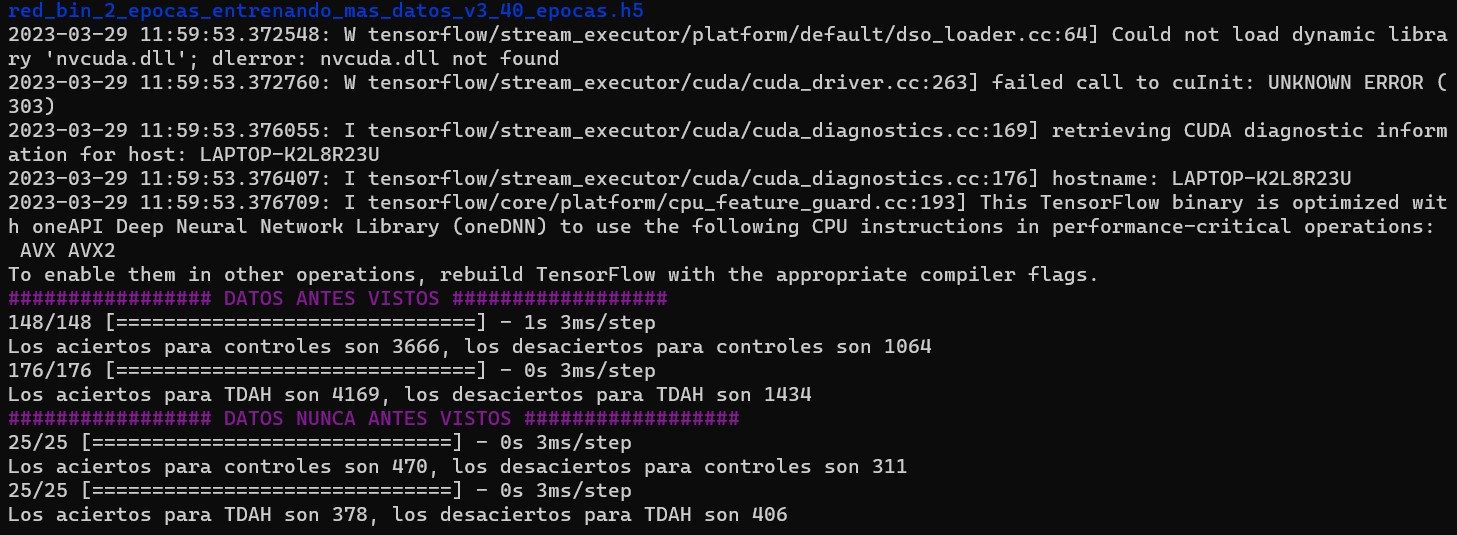

In [8]:
display(Image(filename='40_epochs.jpg'))

Podemos ver cómo en los datos que sí había visto antes, los aciertos siempre son mayores a los desaciertos, ya sea para personas con TDAH o personas CONTROL. Si la red fuera flexible, al mostrarle nuevos electroencefalogramas, debería repetir un comportamiento similar. Podemos ver que difícilmente lo logra... Para los datos nunca antes vistos, al predecir sobre datos de CONTROL los aciertos son ligeramente mayor que los desaciertos, mientras que en los datos de TDAH los aciertos son todavía ligeramente menor a los desaciertos.

Intenté entrenar por más épocas, es decir, al rededor de 60, pero no pude obtener mejores resultados que este. 


Durante la última reunión que tuvimos, plantee que la forma para determinar si una persona tiene TDAH o no sería pasarle un estudio completo cortado en intervalos de 2 segundos. Algunos de esos 2 segundos los clasificará como CONTROL y algunos otros los clasificará como TDAH aunque provengan de la misma persona. Mi propuesta era que observáramos los datos como los que se ven en la imagen. Si hay más predicciones sobre que los datos son TDAH, diremos que esa persona probablente tenga TDAH y viceversa. 